In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings
import scipy
import scipy.misc
from torch.utils.data import DataLoader
import imageio as img

In [2]:
NUM_EPOCHS = 6000
SAMPLE_FREQUENCY = 100
PRINT_FREQUENCY = 10
DEVICE = torch.device("mps" if torch.has_mps else "cpu")
SAVE_PATH = './outputs'
NUM_RESBLOCKS = 8
IMAGE_SIZE = 256



```
# This is formatted as code
```

# ResBlock

In [3]:
from numpy import identity


class ResBlock(nn.Module):
    def __init__(self, in_channels) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
        
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(in_channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        output = self.conv(x)
        output += x
        output = self.relu(output)
        return output


class UpBlock(nn.Module):
    def __init__(self, in_f, out_f, stride=2, add_blur=False):
        super(UpBlock, self).__init__()

        self.shuffle = nn.ConvTranspose2d(
            in_f, out_f, kernel_size=3, stride=stride, padding=0)
        self.has_blur = add_blur
        if self.has_blur:
            self.blur = nn.AvgPool2d(2, 1)

    def forward(self, x):
        x = self.shuffle(x)
        if self.has_blur:
            x = self.blur(x)
        return x


class Generator(nn.Module):
    def __init__(self, conv_dims=64, num_res_blocks=NUM_RESBLOCKS):
        super().__init__()

        # DOWN SIZING
        self.down = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1,
                      padding=7//2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(conv_dims, conv_dims*2, kernel_size=3, stride=2, padding=0, bias=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(conv_dims*2, conv_dims*2, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dims*2),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(conv_dims*2, conv_dims*4, kernel_size=3, stride=2, padding=0, bias=False),
            nn.ReflectionPad2d(1),
            nn.Conv2d(conv_dims*4, conv_dims*4, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dims*4),
            nn.ReLU(inplace=True)
        )

        # Residual Blocks 
        res_layers = []
        for layer in range(num_res_blocks):
            res_layers.append(ResBlock(conv_dims*4))

        self.res_blocks = nn.Sequential(*res_layers)

        # up sampling
        self.up = nn.Sequential(
            UpBlock(conv_dims*4, conv_dims*2, stride=2, add_blur=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(conv_dims*2, conv_dims*2, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dims*2),
            nn.ReLU(inplace=True),

            UpBlock(conv_dims*2, conv_dims, stride=2, add_blur=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(conv_dims, conv_dims, kernel_size=3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(conv_dims),
            nn.ReLU(inplace=True),

            nn.Conv2d(conv_dims, 3, kernel_size=7, stride=1, padding=7//2)
        )

    def forward(self, x):
        x = self.down(x)
        x = self.res_blocks(x)
        x = self.up(x)
        return torch.tanh(x)


# def test():
#     x = torch.randn((5, 3, 256, 256))
#     model = Generator()
#     preds = model(x)
#     print(preds.shape)

# test()

In [4]:
def get_data_loader(image_type, image_dir='Dataset', 
                    image_size=IMAGE_SIZE, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((image_size,image_size)), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [5]:
dataloader_X, test_dataloader_X = get_data_loader(image_type='land')
dataloader_Y, test_dataloader_Y = get_data_loader(image_type='gogh')

The helper image functions!

Text(0.5, 1.0, 'Landscape Pictures')

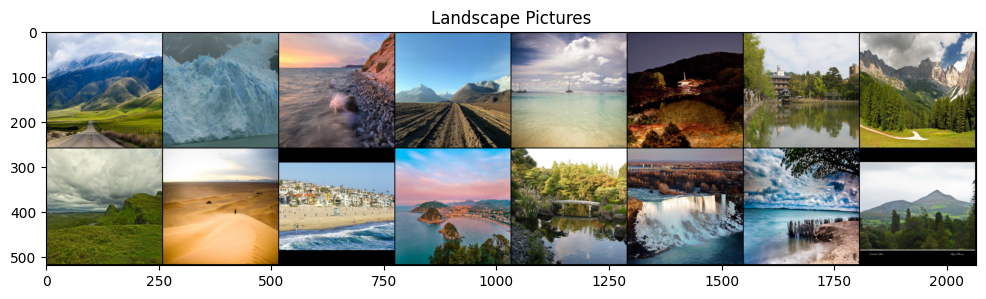

In [6]:
# helper imshow function
def imshow(img):
    npimg = img.numpy() #Numpy img format is RGB
    #transforming to GBR, so the transpose is {1(G), 2(B), 0(R)}
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))
plt.title('Landscape Pictures')

In [7]:
###### scale function

def scale(img,range=[-1,1]):
    min = range[0]
    max = range[1]
    
    #adapting the range
    scaled_img = img * (max-min)
    #shifting value by the desired minimum
    scaled_img = scaled_img + min

    return scaled_img

def merge_images(sources, targets, batch_size=16):
    """Creates a grid consisting of pairs of columns, where the first column in
        each pair contains images source images and the second column in each pair
        contains images generated by the CycleGAN from the corresponding images in
        the first column.
        """
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged

def to_data(x):
    """Converts variable to numpy."""
    x = x.cpu().data.numpy()
    x = ((x +1)*255 / (2)).astype(np.uint8) # rescale to 0-255
    return x

def save_samples(iteration, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir=SAVE_PATH):
    """Saves samples from both generators X->Y and Y->X.
        """
    # move input data to correct device
    device = torch.device("mps")

    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))
    
    X, fake_X = to_data(fixed_X), to_data(fake_X)
    Y, fake_Y = to_data(fixed_Y), to_data(fake_Y)
    
    merged = merge_images(X, fake_Y, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    img.imwrite(path, merged)
    print('Saved {}'.format(path))
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    img.imwrite(path, merged)
    print('Saved {}'.format(path))

Dataloader!

# New section

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                  padding=0, bias=False)
    )

class Discriminator(nn.Module):
    def __init__(self, conv_dim = 64, kernel=4):
        super(Discriminator, self).__init__()
        
        # Convolutional Layers
        self.conv = nn.Sequential(
                        conv3x3(3, 32, stride=1),
                        nn.LeakyReLU(0.2, inplace=True),

                        conv3x3(32, 64, stride=2),
                        nn.LeakyReLU(0.2, inplace=True),
                        conv3x3(64, 128, stride=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True),

                        conv3x3(128, 128, stride=2),
                        nn.LeakyReLU(0.2, inplace=True),
                        conv3x3(128, 256, stride=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True),

                        conv3x3(256, 1, stride=1),  # ??
                        # nn.Sigmoid()  # ??

                    )
     
    
    def forward(self, x):
        # Apply RELU layer to all layers except final layer.
        x = self.conv(x)
        return x

# def test():
#     x = torch.randn((5, 3, 256, 256))
#     model = Discriminator()
#     preds = model(x)
#     print(preds.shape)

# test()

### Loss Functions


In [9]:
def cycle_consistency_loss(real_im, fake_im, l_weight):
    loss = torch.mean(torch.abs(real_im - fake_im))
    return loss*l_weight

def real_mse_loss(disc_out):
    return torch.mean((disc_out - 1)**2)
    
def fake_mse_loss(disc_out):
    return torch.mean(disc_out**2)

## Model Instantiation

In [10]:
def createModel(g_conv_dim=64, n_res_blocks=NUM_RESBLOCKS):
    # Instantiate generators
    G_XtoY = Generator(conv_dims=g_conv_dim, num_res_blocks=n_res_blocks)
    G_YtoX = Generator(conv_dims=g_conv_dim, num_res_blocks=n_res_blocks)
    return G_XtoY, G_YtoX

###### Optimiser

In [11]:
import torch.optim as optim

def get_optimisers(D_paint, D_pic, G_pic2paint, G_paint2pic, lr=1e-4, beta1 = 0.5, beta2 = 0.999, weight_d = 1e-4):
    generator_params = list(G_paint2pic.parameters()) + list(G_pic2paint.parameters())  # Get generator parameters
    generator_optimiser = optim.Adam(generator_params, lr, [beta1, beta2], weight_decay=weight_d)
    d_paint_optimiser = optim.Adam(D_paint.parameters(), lr, [beta1, beta2], weight_decay=weight_d)
    d_pic_optimiser = optim.Adam(D_pic.parameters(), lr, [beta1, beta2], weight_decay=weight_d)
    return generator_optimiser, d_paint_optimiser, d_pic_optimiser

In [ ]:
# import save code


##Initialise Discriminators and Generators
   
disc_paint = Discriminator()
disc_pic = Discriminator()
gen_paint, gen_pic = createModel()
disc_paint.to(DEVICE)
disc_pic.to(DEVICE)
gen_paint.to(DEVICE)
gen_pic.to(DEVICE)

### Training Function


In [13]:
from random import sample


def train_function(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, disc_paint, disc_pic, gen_paint, gen_pic,
                  n_epochs=NUM_EPOCHS):
    
    losses = []
    best_genLoss = 999
    
    #Create fixed test images from the dataloaders
    test_iter_pic = iter(test_dataloader_X)
    test_iter_paint = iter(test_dataloader_Y)
    fixed_pic = test_iter_pic.next()[0]
    fixed_paint = test_iter_paint.next()[0]
    fixed_pic = scale(fixed_pic) # Calls the scale method from the dataloader class.
    fixed_paint = scale(fixed_paint)
    
    ##Initialise optimisers

    generator_optimiser, d_paint_optimiser, d_pic_optimiser = get_optimisers(disc_paint, disc_pic, gen_paint, gen_pic)#
    
    #Pull the correct number of iterations of image from the dataloader
    iter_pic = iter(dataloader_X)
    iter_paint = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_pic), len(iter_paint))

    for epoch in range(1, n_epochs+1):
        if epoch % batches_per_epoch == 0:
            iter_pic = iter(dataloader_X)
            iter_paint = iter(dataloader_Y)
            
        ##Configure images and send to GPU    
        images_pic, _ = iter_pic.next()
        images_paint, _ = iter_paint.next()
        images_paint = scale(images_paint)
        images_pic = scale(images_pic)
        images_pic = images_pic.to(DEVICE)
        images_paint = images_paint.to(DEVICE)
        
        # ~~~~~~ train first discriminator ~~~~~
        
        d_paint_optimiser.zero_grad()   #resets the optimiser
        
        #First, real images
        #NOTE: as I understand it, simply invoking the model and
        #passing in an image will, byy default, call the forward fn of the model
        #if this is for some reason untrue, I will need to rewrite this
        
        paint_out = disc_paint(images_paint)
        d_paint_rloss = real_mse_loss(paint_out)
        
        #Now fakes from the generator
        fake_paint = gen_paint(images_pic)
        paint_out = disc_paint(fake_paint)
        d_paint_floss = fake_mse_loss(paint_out)
        
        #Calculate total loss and backpropagate
        total_paint_loss = d_paint_rloss + d_paint_floss
        total_paint_loss.backward()
        d_paint_optimiser.step()
        
        
        
         # ~~~~~~ train second discriminator ~~~~~
        
        d_pic_optimiser.zero_grad()   #resets the optimiser
        
        #First, real images
        #NOTE: as I understand it, simply invoking the model and
        #passing in an image will, byy default, call the forward fn of the model
        #if this is for some reason untrue, I will need to rewrite this
        
        pic_out = disc_pic(images_pic)
        d_pic_rloss = real_mse_loss(pic_out)
        
        #Now fakes from the generator
        fake_pic = gen_pic(images_paint)
        pic_out = disc_pic(fake_pic)
        d_pic_floss = fake_mse_loss(pic_out)
        
        #Calculate total loss and backpropagate
        total_pic_loss = d_pic_rloss + d_pic_floss
        total_pic_loss.backward()
        d_pic_optimiser.step()
        
        
        # ~~~~~~ train both generators ~~~~~~~
        
        generator_optimiser.zero_grad()
        
        #Painting generation
        fake_paint = gen_paint(images_pic)
        paint_out = disc_paint(fake_paint)
        paint_gen_loss = real_mse_loss(paint_out)
        
        #Now reconstruct the picture from the fake, and compute cycle-consistency loss accordingly
        recon_pic = gen_pic(fake_paint)
        pic_cycle_loss = cycle_consistency_loss(images_pic, recon_pic, l_weight=10)  ##Udacity also set l = 10 here, though I know not why
        
        
        #Repeat for picture generation
        
        fake_pic = gen_pic(images_paint)
        pic_out = disc_pic(fake_pic)
        pic_gen_loss = real_mse_loss(pic_out)
        recon_paint = gen_paint(fake_pic)
        paint_cycle_loss = cycle_consistency_loss(images_paint, recon_paint, l_weight = 10)
        
        ##Calculate net loss and backpropagate to update weights of the kernels
        net_generator_loss = pic_gen_loss + paint_gen_loss + pic_cycle_loss + paint_cycle_loss
        net_generator_loss.backward()
        generator_optimiser.step()

        if (net_generator_loss.item() < best_genLoss):
            best_genLoss = net_generator_loss.item()
            print(net_generator_loss.item())
            save_samples(epoch, fixed_pic,fixed_paint, gen_paint, gen_pic, batch_size=16, sample_dir="./outputs/best_output")
        
        #With loss functions compiled, time to log the losses and save
        #This is taken directly from Udacity lol
        if epoch % PRINT_FREQUENCY == 0:
            losses.append((total_paint_loss.item(), total_pic_loss.item(), net_generator_loss.item()))
            print('Epoch [{:5d}/{:5d}] | Paint Loss: {:6.4f} | Pic Loss: {:6.4f} | Generator Losses: {:6.4f}'.format(
                    epoch, n_epochs, total_paint_loss.item(), total_pic_loss.item(), net_generator_loss.item()))
       
        if epoch % SAMPLE_FREQUENCY == 0:
            gen_paint.eval()
            gen_pic.eval()
            save_samples(epoch, fixed_pic, fixed_paint, gen_paint, gen_pic, batch_size=16)
            gen_paint.train()
            gen_pic.train()
        
    return losses

In [ ]:
print("Working...")

losses = train_function(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, disc_paint, disc_pic, gen_paint, gen_pic, NUM_EPOCHS)

This section of code plots the losses

In [ ]:
# fig, ax1 = plt.subplots()

# fig.set_size_inches(10, 8)

# ax2 = ax1.twinx()




# ax2.plot(np.linspace(0, n_epochs, len(test_loss)),test_loss,'orange',zorder=0 )

# ax2.plot(np.linspace(0, n_epochs, len(val_loss)),val_loss, 'b-',zorder=5)

# ax2.plot(np.linspace(0, n_epochs, len(train_loss)),train_loss, 'r-',zorder=5)

# ax1.plot(test_acc, 'g-')

# ax1.plot(val_acc,'purple')



# ax1.set_xlabel('Epochs')

# ax1.set_ylabel('Accuracy', color='g')

# ax2.set_ylabel('Loss', color='b')

# plt.title("Test Accuracy and Training Loss")

# legend = fig.legend(["Test Accuracy","Validation Accuracy","Test Loss", "Validation Loss", "Train Loss"])

# legend.set_zorder(20)

In [ ]:
# import matplotlib.image as mpimg

# # helper visualization code
# def view_samples(iteration, sample_dir=SAVE_PATH):
    
#     # samples are named by iteration
#     path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
#     path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
#     # read in those samples
#     try: 
#         x2y = mpimg.imread(path_XtoY)
#         y2x = mpimg.imread(path_YtoX)
#     except:
#         print('Invalid number of iterations.')
    
#     fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
#     ax1.imshow(x2y)
#     ax1.set_title('X to Y')
#     ax2.imshow(y2x)
#     ax2.set_title('Y to X')